In [37]:
import pandas as pd
import numpy as np
import sklearn
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from mpl_toolkits.basemap import Basemap
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [38]:
# View all columns on the screen
pd.set_option('max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

In [39]:
query_string1 = '''
                select * from merged order by pickup_datetime asc
'''

In [40]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaximergeddb.sqlite')
# Confirm data is being returned from this query
df = pd.read_sql_query(query_string1, con)
# Verify that result of SQL query is stored in the dataframe
df = df.drop('index', axis=1)
# Let's filter down to Rate codes 1, 2 and 3 - NYC and its surrounding airports.
taxidf = df.copy()
taxidf = taxidf[taxidf.rate_code < 4]
taxidf.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.981850,40.783993,-73.991020,40.770947,CSH,5.5,0.5,0.5,0.00,0.0,6.50
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.976997,40.761559,-74.003853,40.742271,CRD,14.5,0.5,0.5,2.00,0.0,17.50
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.979881,40.776081,-73.982071,40.768272,CRD,4.0,0.5,0.5,1.00,0.0,6.00
14064066,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.942482,40.779572,-73.942482,40.779572,CRD,7.5,0.5,0.5,1.11,0.0,9.61
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-73.998215,40.729637,-73.992798,40.748791,CSH,7.5,0.5,0.5,0.00,0.0,8.50


## Feature Engineering
---

In [41]:
taxidf['tip_percentage'] = 100.0*taxidf['tip_amount']/taxidf['total_amount']
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,16.666667
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0.000000
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,15.492958
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01 00:00:00,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,19.047619
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01 00:00:00,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,15.789474


In [42]:
print "Summary: Tip percentage\n", taxidf.tip_percentage.describe()

Summary: Tip percentage
count    1.405130e+07
mean     8.085164e+00
std      8.310788e+00
min      0.000000e+00
25%      0.000000e+00
50%      7.692308e+00
75%      1.624365e+01
max      9.600000e+01
Name: tip_percentage, dtype: float64


In [43]:
# Was the driver tipped?
taxidf['with_tip'] = (taxidf.tip_percentage>0)*1

In [44]:
taxidf.pickup_datetime = pd.to_datetime(taxidf.pickup_datetime)

In [45]:
# Day of Week, Hour of Day, Week
import datetime as dt
ref_week = dt.datetime(2013,4,1).isocalendar()[1] # first week of september in 2015
taxidf['Week'] = taxidf.pickup_datetime.apply(lambda x:x.isocalendar()[1])-ref_week+1
taxidf['Week_day']  = taxidf.pickup_datetime.apply(lambda x:x.isocalendar()[2])
taxidf['Month_day'] = taxidf.pickup_datetime.apply(lambda x:x.day)
taxidf['Hour'] = taxidf.pickup_datetime.apply(lambda x:x.hour)
taxidf.head(1)

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,with_tip,Week,Week_day,Month_day,Hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.4,-73.9935,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,16.666667,1,1,1,1,0


In [46]:
# create shift variable:  1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)
taxidf['Shift_type'] = np.NAN
taxidf.loc[taxidf[(taxidf.Hour>=7) & (taxidf.Hour<15)].index,'Shift_type'] = 1
taxidf.loc[taxidf[(taxidf.Hour>=15) & (taxidf.Hour<23)].index,'Shift_type'] = 2
taxidf.loc[taxidf[taxidf.Shift_type.isnull()].index,'Shift_type'] = 3
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,with_tip,Week,Week_day,Month_day,Hour,Shift_type
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,16.666667,1,1,1,1,0,3.0
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0.000000,0,1,1,1,0,3.0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,15.492958,1,1,1,1,0,3.0
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,19.047619,1,1,1,1,0,3.0
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,15.789474,1,1,1,1,0,3.0


In [47]:
# Calculate the average taxi speed per hour
taxidf2 = taxidf.groupby(['medallion','Month_day','Hour'])\
                .agg({'trip_distance':sum})\
                .rename(columns={'trip_distance':'avgspd_in_hour'}).reset_index()
taxidf = taxidf.merge(taxidf2, on=['medallion','Month_day','Hour'])
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,with_tip,Week,Week_day,Month_day,Hour,Shift_type,avgspd_in_hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,16.666667,1,1,1,1,0,3.0,7.00
1,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:24:49,2013-04-01 00:26:17,2,88,0.30,-73.971230,40.757462,-73.975060,40.751656,CSH,3.5,0.5,0.5,0.0,0.0,4.5,0.000000,0,1,1,1,0,3.0,7.00
2,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:50:29,2013-04-01 01:03:17,1,767,3.30,-73.990074,40.756126,-73.985527,40.726139,CRD,13.0,0.5,0.5,2.8,0.0,16.8,16.666667,1,1,1,1,0,3.0,7.00
3,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0.000000,0,1,1,1,0,3.0,10.29
4,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,15.492958,1,1,1,1,0,3.0,0.97


In [48]:
taxidf3 = taxidf.groupby(['medallion','Month_day','Hour'])\
                        .agg({'rate_code':len})\
                        .rename(columns={'rate_code':'trips_per_hour'}).reset_index()
taxidf = taxidf.merge(taxidf3, on=['medallion','Month_day','Hour'])
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,with_tip,Week,Week_day,Month_day,Hour,Shift_type,avgspd_in_hour,trips_per_hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,16.666667,1,1,1,1,0,3.0,7.00,3
1,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:24:49,2013-04-01 00:26:17,2,88,0.30,-73.971230,40.757462,-73.975060,40.751656,CSH,3.5,0.5,0.5,0.0,0.0,4.5,0.000000,0,1,1,1,0,3.0,7.00,3
2,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:50:29,2013-04-01 01:03:17,1,767,3.30,-73.990074,40.756126,-73.985527,40.726139,CRD,13.0,0.5,0.5,2.8,0.0,16.8,16.666667,1,1,1,1,0,3.0,7.00,3
3,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0.000000,0,1,1,1,0,3.0,10.29,1
4,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,15.492958,1,1,1,1,0,3.0,0.97,1


In [49]:
#Filter down to all trips below 200mph
taxidf = taxidf[taxidf['avgspd_in_hour'] < 200]
taxidf.avgspd_in_hour.max()

180.40000000000001

## Using a linear regression model to predict tips
---

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

# Basic Linear Model
y = taxidf.tip_percentage
X = taxidf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
            'dropoff_longitude','dropoff_latitude','trip_distance','Hour',
            'Shift_type', 'Week', 'Week_day', 'Month_day']]

(X_train, X_test, y_train, y_test) = train_test_split(X, y)

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()
huber = HuberRegressor()
ransac = RANSACRegressor()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [86]:
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [87]:
ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_trials=100, min_samples=None,
        random_state=None, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [88]:
# Print R_squared
print "The R-squared of the RANSAC model is: ", ransac.score(X_test, y_test)
print "The R-squared of the Huber model is: ", huber.score(X_test, y_test)
print "The R-squared of the OLS model is: ", ols.score(X_test, y_test)

The R-squared of the RANSAC model is:  -1.35548549343
The R-squared of the Huber model is:  0.00495728856283
The R-squared of the OLS model is:  0.0119882068415


In [89]:
from sklearn.metrics import median_absolute_error, mean_squared_error
print "Using OLS Regression on average our estimate of taxi fare misses by", \
median_absolute_error(ols.predict(X_test), y_test)
print "Using RANSAC Regression on average our estimate of taxi fares misses by", \
median_absolute_error(ransac.predict(X_test), y_test)
print "Using Huber Regression on average our estimate of taxi fares misses by", \
median_absolute_error(huber.predict(X_test), y_test)

Using OLS Regression on average our estimate of taxi fare misses by 7.88893638013
Using RANSAC Regression on average our estimate of taxi fares misses by 8.62225341797
Using Huber Regression on average our estimate of taxi fares misses by 7.72088650231


In [90]:
print "Using OLS Regression the mean square error of taxi fares is", \
mean_squared_error(ols.predict(X_test), y_test)
print "Using RANSAC Regression the mean square error of taxi fares is", \
mean_squared_error(ransac.predict(X_test), y_test)
print "Using Huber Regression the mean square error of taxi fares is", \
mean_squared_error(huber.predict(X_test), y_test)

Using OLS Regression the mean square error of taxi fares is 68.2609424889
Using RANSAC Regression the mean square error of taxi fares is 162.738603844
Using Huber Regression the mean square error of taxi fares is 68.7467029946


Even though the OLS model has the highest R-square and MSE when we score by the median absolute error, the RANSAC regressor performs the best.

In [91]:
ypred_ols = ols.predict(X_test)
ypred_r = ransac.predict(X_test)
ypred_h = huber.predict(X_test)

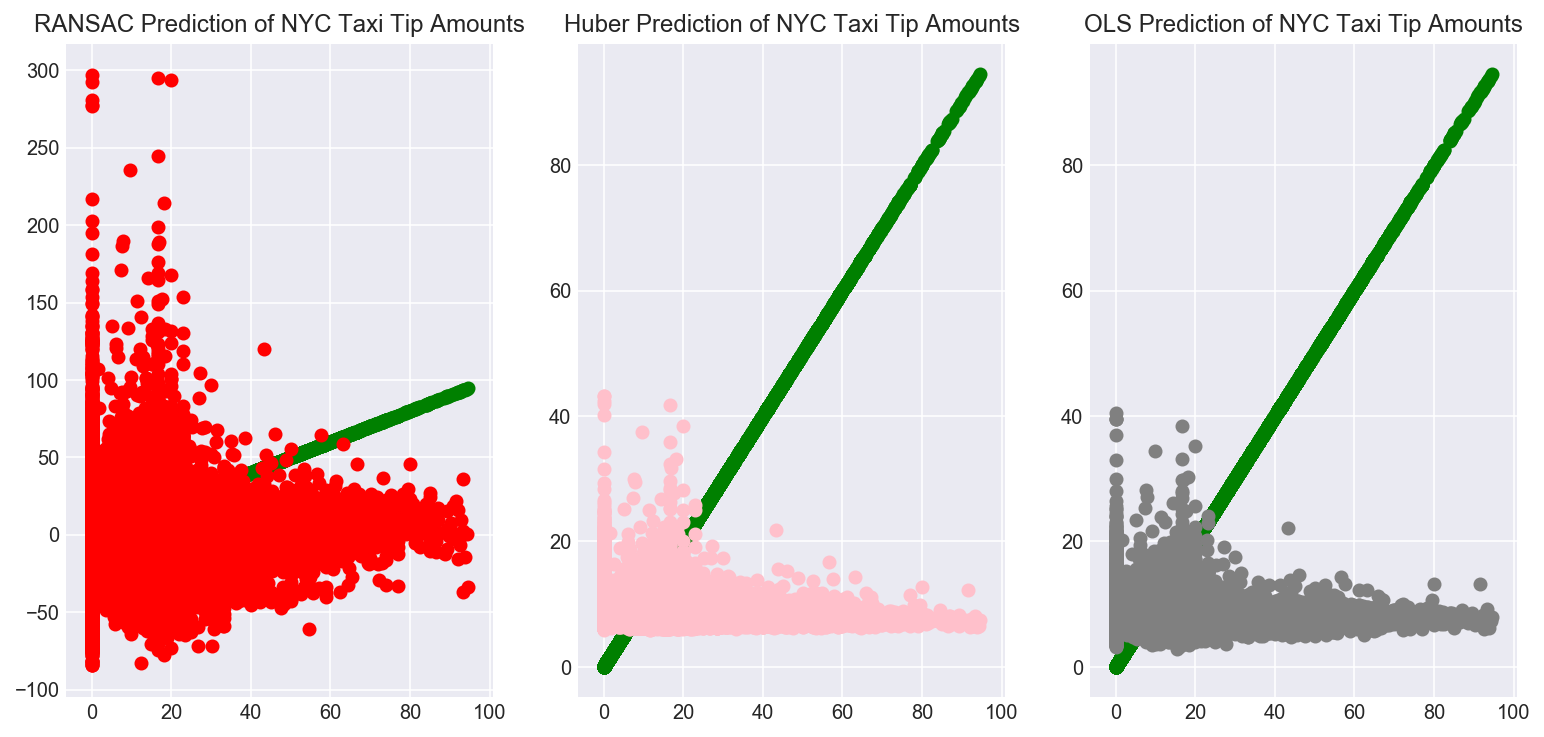

In [92]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(13,6))
ax1.scatter(y_test, y_test, c='green')
ax1.scatter(y_test, ypred_r, c='red')
ax1.set_title('RANSAC Prediction of NYC Taxi Tip Amounts')
ax2.scatter(y_test, y_test, c='green')
ax2.scatter(y_test, ypred_h, c='pink')
ax2.set_title('Huber Prediction of NYC Taxi Tip Amounts')
ax3.scatter(y_test, y_test, c='green')
ax3.scatter(y_test, ypred_ols, c='gray')
ax3.set_title('OLS Prediction of NYC Taxi Tip Amounts')
None

In [93]:
import statsmodels.api as sm
y = taxidf.tip_percentage
X1 = taxidf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
            'dropoff_longitude','dropoff_latitude','trip_distance','Hour',
            'Shift_type', 'Week', 'Week_day', 'Month_day']]
X1 = sm.add_constant(X1)
res1 = sm.OLS(y, X1, missing='drop').fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:         tip_percentage   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                 1.525e+04
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        20:14:19   Log-Likelihood:            -4.9608e+07
No. Observations:            14050975   AIC:                         9.922e+07
Df Residuals:                14050963   BIC:                         9.922e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -386.2865      7.80

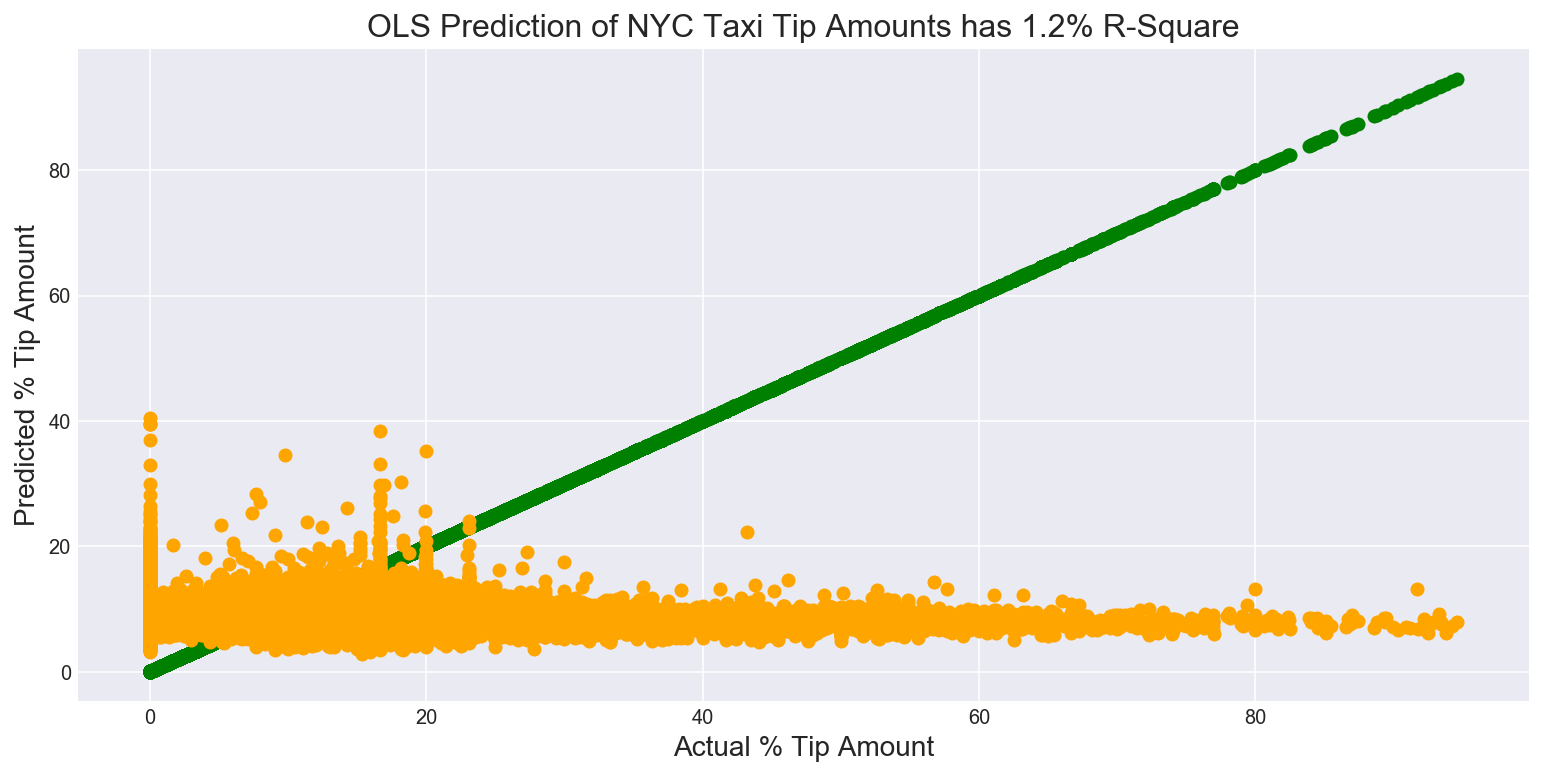

In [97]:
fig, ax = plt.subplots(figsize=(13,6))
ax.scatter(y_test, y_test, c='green')
ax.scatter(y_test, ypred_ols, c='orange')
ax.set_title('OLS Prediction of NYC Taxi Tip Amounts has 1.2% R-Square', fontsize=16)
ax.set_ylabel('Predicted % Tip Amount', fontsize=14)
ax.set_xlabel('Actual % Tip Amount', fontsize=14)
None

### 5-Fold Cross Validation

In [95]:
ols = LinearRegression()
sklearn.model_selection.cross_val_score(ols, X, y, cv=5)

array([ 0.0110939 ,  0.01235809,  0.0128117 ,  0.01120998,  0.00997141])

In [96]:
sklearn.model_selection.cross_val_score(ols, X, y, cv=5).mean()

0.011489016740272983

**Pretty bad fit with a linear model.**

## Airport Fares
---

In [99]:
airportdf = taxidf.copy()
nonairportdf = taxidf.copy()
airportdf = airportdf[airportdf.rate_code <> 1]
nonairportdf = nonairportdf[nonairportdf.rate_code == 1]
airportdf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,with_tip,Week,Week_day,Month_day,Hour,Shift_type,avgspd_in_hour,trips_per_hour
204,297EE2907213112ABA14732D3781808C,CCF62CE81226C96A028907DBBF36720D,CMT,2,2013-04-01 00:00:13,2013-04-01 00:00:36,1,22,7.50,-74.006439,40.718166,-74.006485,40.718143,CRD,52.0,0.0,0.5,10.5,0.00,63.00,16.666667,1,1,1,1,0,3.0,10.60,2
208,81C4DF9BA06C93EDCC87F6702E0B22F5,51FA34275A96BB8C216F2CBA8A18D0C9,CMT,2,2013-04-01 00:00:13,2013-04-01 00:07:25,1,431,1.70,-73.988914,40.718857,-74.007393,40.733482,CSH,52.0,0.0,0.5,0.0,0.00,52.50,0.000000,0,1,1,1,0,3.0,1.70,1
5659,D147E34985C6C53EB978954C12667FDA,EE3B97473E38E69D0216927005CE3172,CMT,2,2013-04-01 00:18:10,2013-04-01 00:27:22,1,552,2.10,-73.987267,40.744686,-73.992851,40.721375,CSH,52.0,0.0,0.5,0.0,0.00,52.50,0.000000,0,1,1,1,0,3.0,6.90,2
5906,5DFA10705410FA86ECFC6447038BF228,24D86F1D5547AE45D4E5FD79D8949064,VTS,2,2013-04-01 00:20:00,2013-04-01 00:32:00,2,720,8.75,-73.857826,40.736092,-73.997910,40.718147,CSH,52.0,0.0,0.5,0.0,0.00,52.50,0.000000,0,1,1,1,0,3.0,9.41,2
6146,D932DC772B89F69D30F03FB095424F97,F5AE2E36090433DFE4142AFC19AFD495,CMT,2,2013-04-01 00:21:43,2013-04-01 00:35:24,1,820,12.20,-73.905167,40.768223,-73.958923,40.763676,CRD,52.0,0.0,0.5,3.0,5.33,60.83,4.931777,1,1,1,1,0,3.0,12.20,1


In [101]:
target = airportdf.tip_percentage
features = airportdf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
                    'dropoff_longitude','dropoff_latitude','trip_distance','Hour',
                    'Shift_type', 'Week', 'Week_day', 'Month_day']]

(X_train, X_test, y_train, y_test) = train_test_split(features, target)

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()
huber = HuberRegressor()
ransac = RANSACRegressor()
ts = TheilSenRegressor()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [102]:
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [103]:
ts.fit(X_train, y_train)

TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)

In [104]:
# Print R_squared
print "The R-squared of the Theil-Sen model for Airport Fares is: ", ts.score(X_test, y_test)
print "The R-squared of the Huber model for Airport Fares is: ", huber.score(X_test, y_test)
print "The R-squared of the OLS model for Airport Fares is: ", ols.score(X_test, y_test)

The R-squared of the Theil-Sen model for Airport Fares is:  -0.001066749682
The R-squared of the Huber model for Airport Fares is:  0.0177062613615
The R-squared of the OLS model for Airport Fares is:  0.0239485958884


In [105]:
# Median Absolute Error and Mean Squared Error
from sklearn.metrics import median_absolute_error, mean_squared_error
print "Using OLS Regression on average our estimate of Airport taxi fares misses by", \
median_absolute_error(ols.predict(X_test), y_test)
print "Using Theil-Sen Regression on average our estimate of Airport taxi fares misses by", \
median_absolute_error(ts.predict(X_test), y_test)
print "Using Huber Regression on average our estimate of Airport taxi fares misses by", \
median_absolute_error(huber.predict(X_test), y_test)

Using OLS Regression on average our estimate of Airport taxi fares misses by 7.53064204852
Using Theil-Sen Regression on average our estimate of Airport taxi fares misses by 7.67687312097
Using Huber Regression on average our estimate of Airport taxi fares misses by 7.46355795185


In [106]:
print "Using OLS Regression on average our mean squared error is", \
mean_squared_error(ols.predict(X_test), y_test)
print "Using Theil-Sen Regression on average our mean squared error is", \
mean_squared_error(ts.predict(X_test), y_test)
print "Using Huber Regression on average our mean squared error is", \
mean_squared_error(huber.predict(X_test), y_test)

Using OLS Regression on average our mean squared error is 68.2448100763
Using Theil-Sen Regression on average our mean squared error is 69.9938649932
Using Huber Regression on average our mean squared error is 68.6812696034


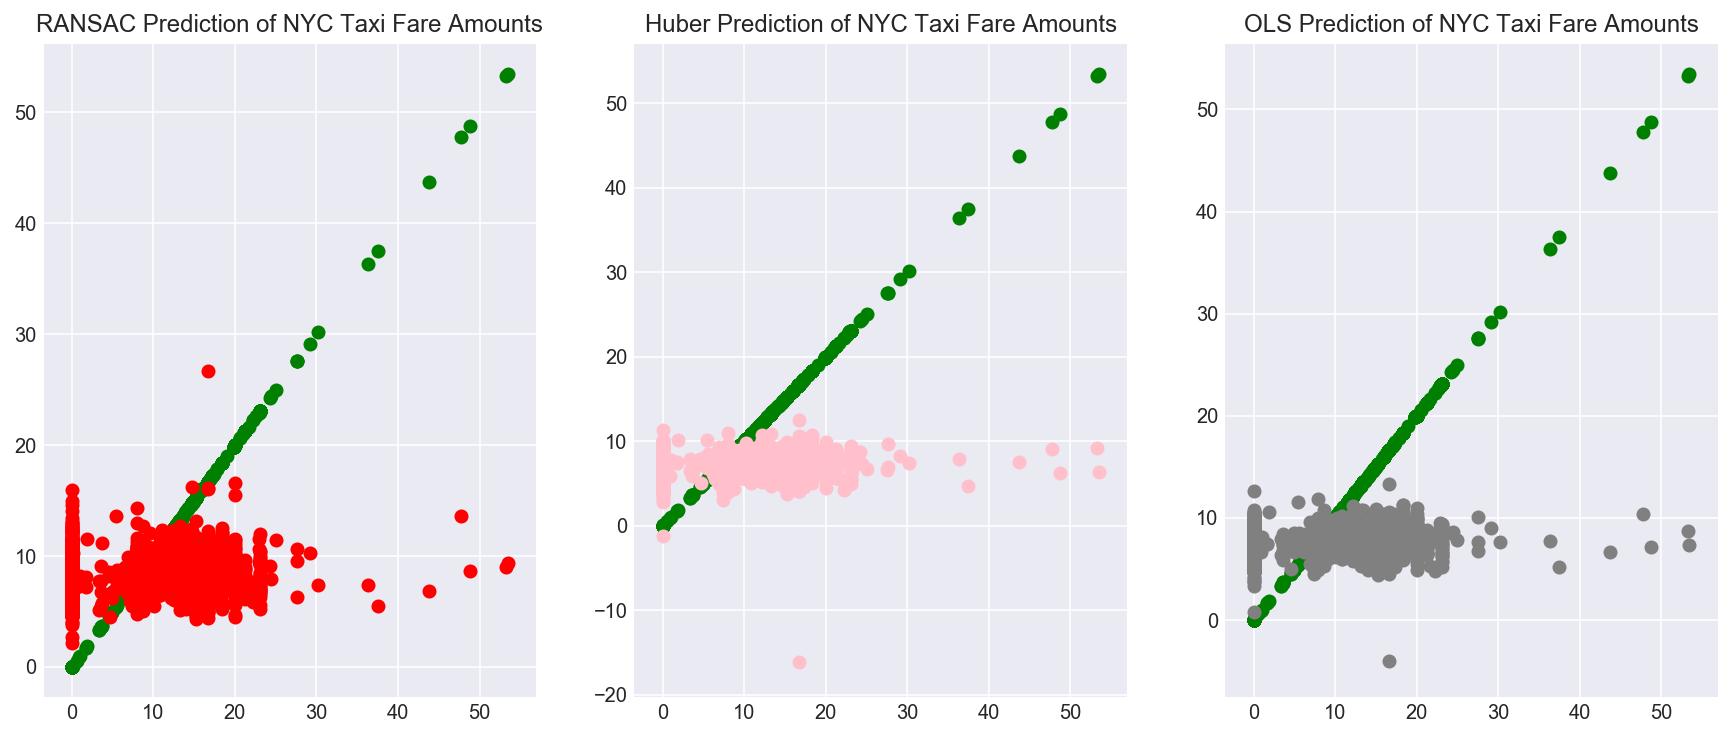

In [107]:
ypred_ols = ols.predict(X_test)
ypred_ts = ts.predict(X_test)
ypred_h = huber.predict(X_test)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,6))
ax1.scatter(y_test, y_test, c='green')
ax1.scatter(y_test, ypred_ts, c='red')
ax1.set_title('RANSAC Prediction of NYC Taxi Fare Amounts')
ax2.scatter(y_test, y_test, c='green')
ax2.scatter(y_test, ypred_h, c='pink')
ax2.set_title('Huber Prediction of NYC Taxi Fare Amounts')
ax3.scatter(y_test, y_test, c='green')
ax3.scatter(y_test, ypred_ols, c='gray')
ax3.set_title('OLS Prediction of NYC Taxi Fare Amounts')
None

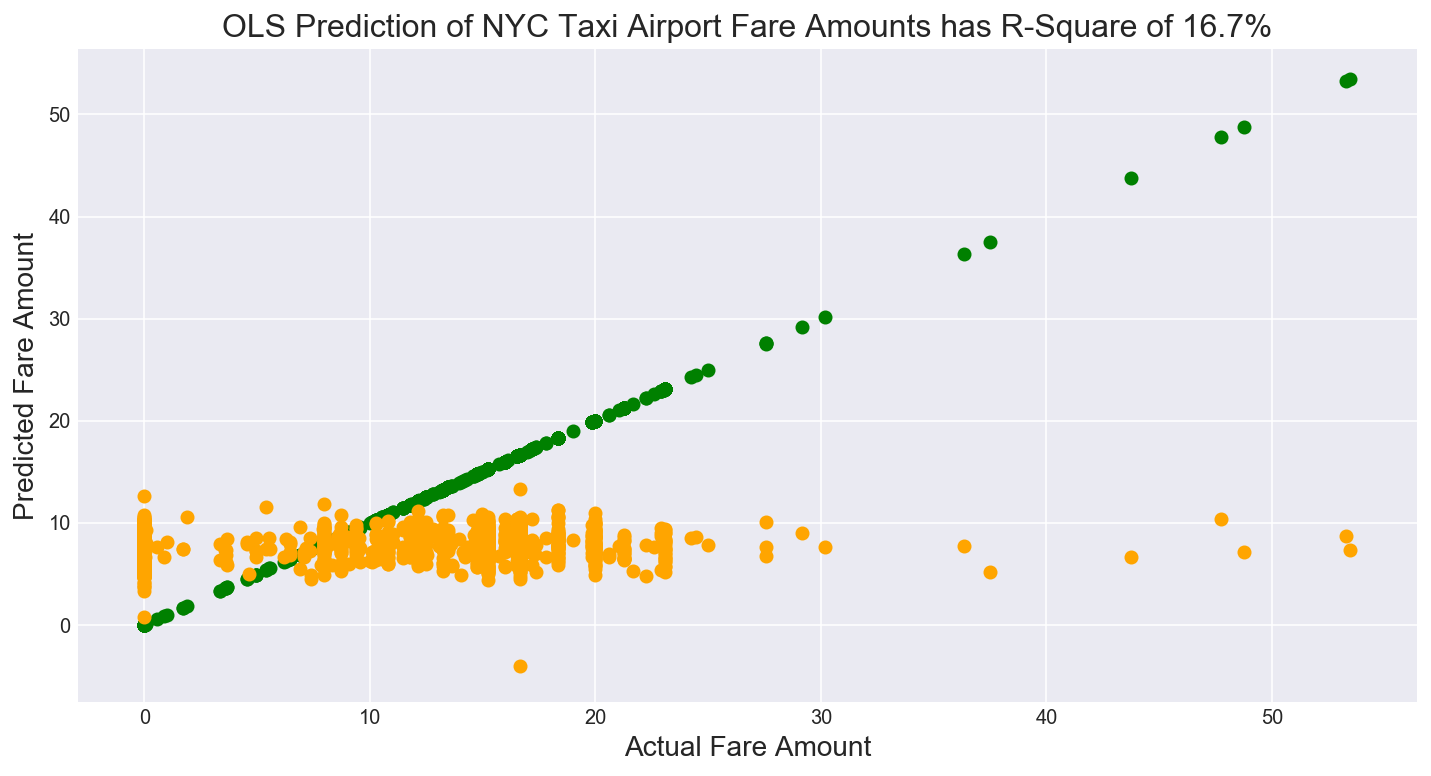

In [108]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y_test, y_test, c='green')
ax.scatter(y_test, ypred_ols, c='orange')
ax.set_title('OLS Prediction of NYC Taxi Airport Fare Amounts has R-Square of 16.7%', fontsize=16)
ax.set_ylabel('Predicted Fare Amount', fontsize=14)
ax.set_xlabel('Actual Fare Amount', fontsize=14)
None

## Can we do better at predicting airport tips using a Neural Network model?
---

In [113]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

# split into input (X) and output (Y) variables
X = airportdf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
                    'dropoff_longitude','dropoff_latitude','trip_distance','Hour',
                    'Shift_type', 'Week', 'Week_day', 'Month_day']]
Y = airportdf.tip_percentage

In [114]:
# Create a neural network function to pass it on to the Keras Regressor
def build_neural_network():
    model = Sequential()
    model.add(Dense(10, input_dim=12, kernel_initializer='random_normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='random_normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [115]:
model = KerasRegressor(build_fn=build_neural_network, epochs=300, verbose=0)
results = cross_val_score(estimator=model, X=np.array(X), y=np.array(Y), cv=10)
print("Using a Neural Network the Mean Square Error of airport fares is %.2f (%.2f)" % (results.mean(), results.std()))

Using a Neural Network the Mean Square Error of airport fares is 68.58 (3.76)


Better than the Huber and Theil-Sen models but not the OLS model.